In [2]:
# Install requirements
!apt install unrar
!pip install pyunpack patool

# Import libraries
from pyunpack import Archive
import os

# Define paths
rar_path = '/content/drive/MyDrive/Colab Dataset/split_dataset.rar'
extract_path = '/content/dataset'

# Create the extraction directory
os.makedirs(extract_path, exist_ok=True)

# Extract the .rar file
Archive(rar_path).extractall(extract_path)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [21]:
import tensorflow as tf

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Using GPU: ", tf.test.gpu_device_name())

Num GPUs Available:  1
Using GPU:  /device:GPU:0


In [4]:
# ✅ STEP 1: Install dependencies
!pip install -q tensorflow matplotlib scikit-learn opencv-python

# ✅ STEP 2: Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import cv2
from google.colab import files

In [24]:
img_size = (117, 256)
batch_size = 32

base_dir = "/content/dataset/split_dataset"
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

In [25]:
# ✅ STEP 4: Data Loaders
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
test_data = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

Found 28000 images belonging to 8 classes.
Found 10573 images belonging to 8 classes.
Found 10585 images belonging to 8 classes.


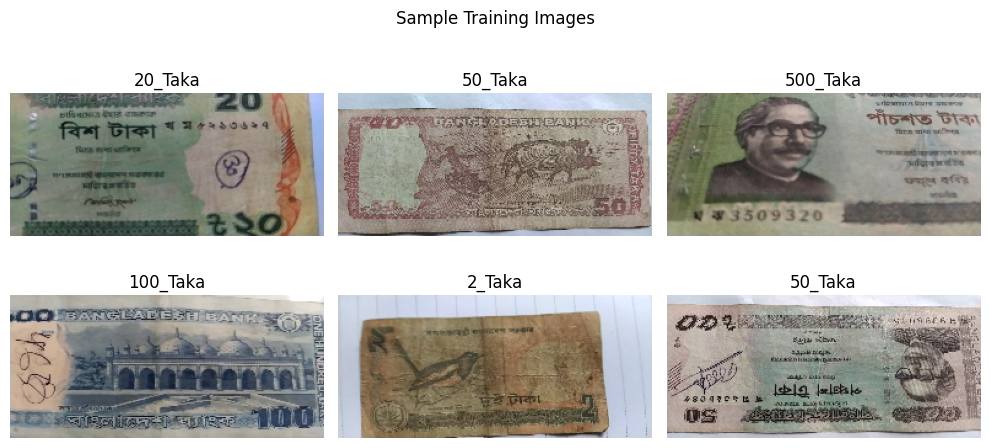

In [29]:
# ✅ STEP 5: Visualize Sample Training Images
x_batch, y_batch = next(train_data)
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    label = list(train_data.class_indices.keys())[np.argmax(y_batch[i])]
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.show()

In [30]:
# ✅ STEP 6: Build & Compile ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(117, 256, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_data.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# ✅ STEP 7: Train the Model with EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,             # Stop after 3 epochs without improvement
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_data,
    epochs=30,               # Increase max epochs (EarlyStopping will cut early)
    validation_data=val_data,
    callbacks=[early_stop]
)


Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 97s 99ms/step - accuracy: 0.2461 - loss: 1.9398 - val_accuracy: 0.4458 - val_loss: 1.5340
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.4308 - loss: 1.4722 - val_accuracy: 0.5747 - val_loss: 1.2614
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 76s 87ms/step - accuracy: 0.4996 - loss: 1.3116 - val_accuracy: 0.6459 - val_loss: 1.1083
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 75s 86ms/step - accuracy: 0.5512 - loss: 1.1989 - val_accuracy: 0.6787 - val_loss: 1.0126
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 76s 87ms/step - accuracy: 0.5835 - loss: 1.1077 - val_accuracy: 0.6989 - val_loss: 0.9296
Epoch 6/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 75s 86ms/step - accuracy: 0.6059 - loss: 1.0449 - val_accuracy: 0.7124 - val_loss: 0.8485
Epoch 7/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 75s 85ms/step - accuracy: 0.6374 - loss: 0.9798 - val_accuracy: 0.7413 - val_loss: 0.7884
Epoch 8/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 76s 87ms/step - accuracy: 0.6552 - loss: 0.9274 - 

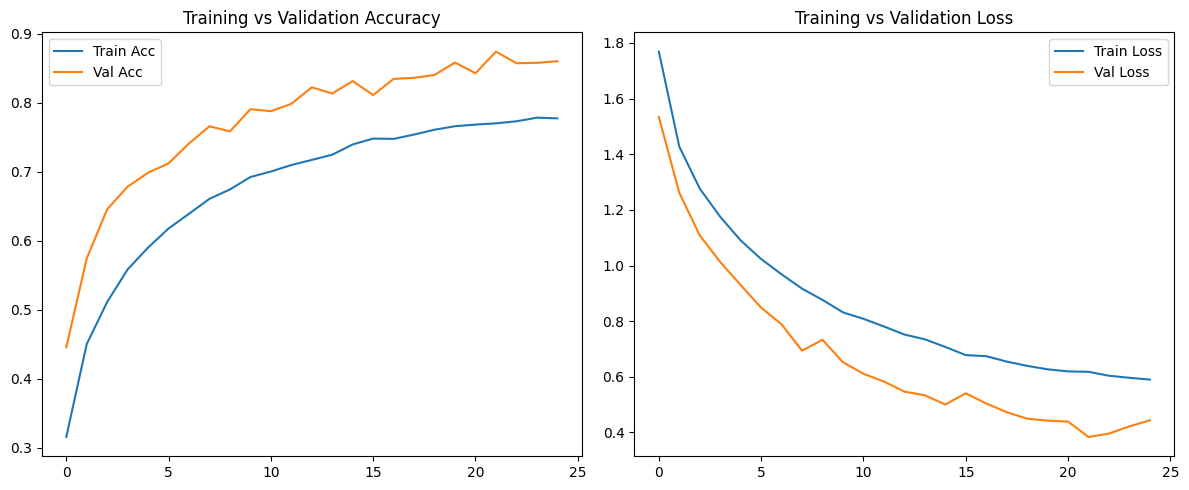

In [32]:
# ✅ STEP 8: Plot Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

331/331 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step


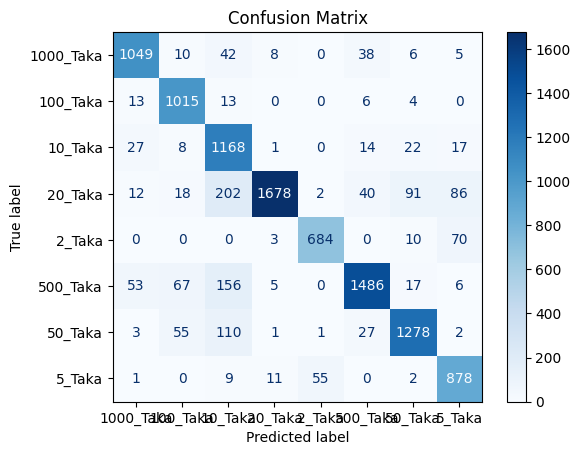

Classification Report:

              precision    recall  f1-score   support

   1000_Taka       0.91      0.91      0.91      1158
    100_Taka       0.87      0.97      0.91      1051
     10_Taka       0.69      0.93      0.79      1257
     20_Taka       0.98      0.79      0.87      2129
      2_Taka       0.92      0.89      0.91       767
    500_Taka       0.92      0.83      0.87      1790
     50_Taka       0.89      0.87      0.88      1477
      5_Taka       0.83      0.92      0.87       956

    accuracy                           0.87     10585
   macro avg       0.88      0.89      0.88     10585
weighted avg       0.89      0.87      0.87     10585



In [33]:
# ✅ STEP 9: Confusion Matrix & Classification Report
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))



Saving 50 (203).png to 50 (203).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


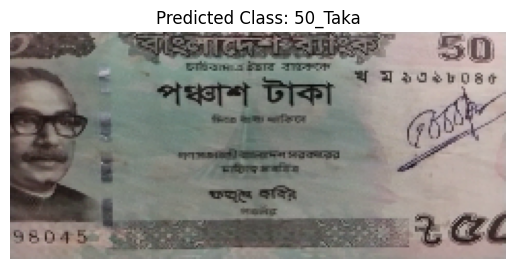

In [50]:
# ✅ STEP 10: Custom Prediction from Image Upload
uploaded = files.upload()
for fname in uploaded.keys():
    img_path = fname
    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    class_label = list(train_data.class_indices.keys())[class_idx]

    plt.imshow(img)
    plt.title(f"Predicted Class: {class_label}")
    plt.axis('off')
    plt.show()

In [51]:
model.save("Resnet_SplitDataset.h5")